### Generate data with the general dataset from VRS 
Format of general dataset
```
ucl_east/
    seq/
        000000.color.png
        000000.depth.png (mm)
        000000.semantic.png (optional)
    poses.txt (TUM format: timestamp tx ty tz qx qy qz qw)
    intrinsics.txt (format: fx fy cx cy width height)
    gps.txt (format: timestamp, latitude, longitude, altitude, speed, accuracy)
```

#### Pipeline:
1. Load the VRS file
2. Load the MPS trajectory
3. Read through all images
4. For each image, find the nearest pose of the image, compute the pose of the camera, rotate image, and save
5. Save poses, intrinsics, and gps to files

In [1]:
import os
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
from projectaria_tools.core.mps.utils import get_nearest_pose
import projectaria_tools.core.mps as mps
from projectaria_tools.core.sophus import SO3, SE3, interpolate, iterativeMean
import numpy as np
import copy
from PIL import Image

from matplotlib import pyplot as plt
vrs_data_path = "/Rocket_ssd/dataset/data_litevloc/map_multisession_eval/raw_vrs/ucl_campus"
out_data_path = "/Rocket_ssd/dataset/data_litevloc/map_multisession_eval/raw_vrs/ucl_campus"
# Input data
vrsfile = os.path.join(vrs_data_path, "vrs_withrgb", "ucl_campus_20241202_1421.vrs")
session_id = 6
open_traj_file = os.path.join(vrs_data_path, f"ucl_campus_multiagent_20241202_1746_10sessions/{session_id}/slam/open_loop_trajectory.csv")
closed_traj_file = os.path.join(vrs_data_path, f"ucl_campus_multiagent_20241202_1746_10sessions/{session_id}/slam/closed_loop_trajectory.csv")
# Output data
out_dir = os.path.join(out_data_path, "out_general_ucl_campus_20241202_1421")
os.makedirs(out_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, "seq"), exist_ok=True)

In [2]:
# Load VRS file
provider = data_provider.create_vrs_data_provider(vrsfile)
assert provider is not None, "Cannot open file"
# Load trajectories
# Definition of open-loop (VIO) and closed-loop (bundle adjustment) trajectory:
#   https://facebookresearch.github.io/projectaria_tools/docs/data_formats/mps/slam/mps_trajectory#open-loop-trajectory
open_loop_traj = mps.read_open_loop_trajectory(open_traj_file)
closed_loop_traj = mps.read_closed_loop_trajectory(closed_traj_file)

Loaded #open loop trajectory poses records: 84751
Loaded #closed loop trajectory poses records: 84685


[ProgressLogger][INFO]: 2024-12-05 15:33:22: Opening /Rocket_ssd/dataset/data_litevloc/map_multisession_eval/raw_vrs/ucl_campus/vrs_withrgb/ucl_campus_20241202_1421.vrs...
[VRSIndexRecord][WARNING]: 9 record(s) not sorted properly. Sorting index.
[MultiRecordFileReader][DEBUG]: Opened file '/Rocket_ssd/dataset/data_litevloc/map_multisession_eval/raw_vrs/ucl_campus/vrs_withrgb/ucl_campus_20241202_1421.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 281-1/gps activated
[VrsDataProvider][INFO]: streamId 282-1/wps activated
[VrsDataProvider][INFO]: streamId 283-1/bluetooth activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1201-

In [3]:
# NOTE(gogojjh): not used
# import cv2
# image_path = os.path.join(data_path, "obs_image_example.png")
# ref_img = cv2.imread(image_path)
# ref_img_lab = cv2.cvtColor(ref_img, cv2.COLOR_BGR2LAB)
# plt.figure(figsize=(5,5))
# plt.imshow(ref_img, cmap='gray', vmin=0, vmax=255)
# plt.title("Reference image")
# plt.axis('off')

In [4]:
# NOTE(gogojjh): not used
def reduce_image_domain_gap(tar_img, domain_unified_flag=False):
    if domain_unified_flag:
#         import cv2
#         import numpy as np
#         from skimage import exposure

#         tar_img_lab = cv2.cvtColor(tar_img, cv2.COLOR_BGR2LAB)
#         tar_matched = np.empty_like(tar_img_lab)
#         for i in range(3):
#             tar_matched[:, :, i] = exposure.match_histograms(tar_img_lab[:, :, i], ref_img_lab[:, :, i])
#         tar_matched_bgr = cv2.cvtColor(tar_matched, cv2.COLOR_LAB2BGR)
#         return tar_matched_bgr
        return tar_img
    else:
        return tar_img

In [5]:
# NOTE(gogojjh): helper function
valid_functions = []
for key in dir(provider):
    if "__" not in key:
        valid_functions.append(key)
print(valid_functions)

print("Show all streams and sensors:")
streams = provider.get_all_streams()
for stream_id in streams:
    label = provider.get_label_from_stream_id(stream_id)
    print(
        f"stream_id: [{stream_id}] convert to label: [{label}] and back: [{provider.get_stream_id_from_label(label)}]"
    )

['check_stream_is_active', 'check_stream_is_type', 'convert_from_device_time_to_synctime_ns', 'convert_from_device_time_to_timecode_ns', 'convert_from_synctime_to_device_time_ns', 'convert_from_timecode_to_device_time_ns', 'deliver_queued_sensor_data', 'get_all_streams', 'get_audio_configuration', 'get_audio_data_by_index', 'get_audio_data_by_time_ns', 'get_barometer_configuration', 'get_barometer_data_by_index', 'get_barometer_data_by_time_ns', 'get_bluetooth_configuration', 'get_bluetooth_data_by_index', 'get_bluetooth_data_by_time_ns', 'get_configuration', 'get_default_deliver_queued_options', 'get_device_calibration', 'get_file_tags', 'get_first_time_ns', 'get_first_time_ns_all_streams', 'get_gps_configuration', 'get_gps_data_by_index', 'get_gps_data_by_time_ns', 'get_image_configuration', 'get_image_data_by_index', 'get_image_data_by_time_ns', 'get_imu_configuration', 'get_imu_data_by_index', 'get_imu_data_by_time_ns', 'get_index_by_time_ns', 'get_label_from_stream_id', 'get_last_

In [6]:
# Read the GPS data
stream_id = provider.get_stream_id_from_label("gps")
num_data = provider.get_num_data(stream_id)
latitude, longitude, altitude, accuracy, speed, timestamps = [], [], [], [], [], []
for index in range(0, num_data):
  gps_data = provider.get_gps_data_by_index(stream_id, index)
  latitude.append(gps_data.latitude)
  longitude.append(gps_data.longitude)
  altitude.append(gps_data.altitude)
  accuracy.append(gps_data.accuracy)
  speed.append(gps_data.speed)
  timestamps.append(gps_data.capture_timestamp_ns * 1e-9)

# Test
gps_data = provider.get_gps_data_by_index(stream_id, num_data - 100)
print(f"GPS data: {gps_data.latitude}, {gps_data.longitude}, {gps_data.altitude}, {gps_data.speed}, {gps_data.capture_timestamp_ns}")
query_timestamp = gps_data.capture_timestamp_ns
gps_data = provider.get_gps_data_by_time_ns(stream_id, query_timestamp,  TimeDomain.DEVICE_TIME)
print(f"GPS data: {gps_data.latitude}, {gps_data.longitude}, {gps_data.altitude}, {gps_data.speed}, {gps_data.capture_timestamp_ns}")


GPS data: 0.0, 0.0, 0.0, 0.0, 0
GPS data: 0.0, 0.0, 0.0, 0.0, 0


In [7]:
# DEBUG(gogojjh): check the pose data
# print(f"Image device timestamp: {img_timestamp / 1e9}")
# print(f"Open Pose device timestamp: {pose_info_open.tracking_timestamp.total_seconds()}")
# print(f"Open Pose utc timestamp: {pose_info_open.utc_timestamp}")
# print(f"Closed Pose device timestamp: {pose_info_closed.tracking_timestamp.total_seconds()}")
# print(f"Closed Pose utc timestamp: {pose_info_closed.utc_timestamp}")
# print(f"{pose_info_open.utc_timestamp.total_seconds():.6f}")
# print(f"{pose_info_closed.utc_timestamp.total_seconds():.6f}")
#######

In [8]:
flag_debug = False
# Initialize parameters
poses_open = np.zeros((0, 8))      # timestamp (utc), tx, ty, tz, qw, qx, qy, qz (open_loop)
poses_closed = np.zeros((0, 8)) # timestamp (utc), tx, ty, tz, qw, qx, qy, qz (closed_loop)
intrinsics = np.zeros((0, 6)) # fx, fy, cx, cy, width, height
gps_data = np.zeros((0, 6))   # timestamp, lat, lon, alt, speed, accuracy
img_save_idx = 0
# Load image
camera_label = "camera-rgb"; camera_stream_id = provider.get_stream_id_from_label(camera_label)
camera_num_data = provider.get_num_data(camera_stream_id)
print(f"Stream ID (camera): {camera_stream_id} with {camera_num_data} data")
# Load GPS
gps_label = "gps"; gps_stream_id = provider.get_stream_id_from_label(gps_label)
gps_num_data = provider.get_num_data(gps_stream_id)
print(f"Stream ID (gps): {gps_stream_id} with {gps_num_data} data")

# Set a initial pose
init_pose_open, init_pose_closed = False, False
T_offset_open, T_offset_closed = SE3().from_matrix(np.eye(4, 4)), SE3().from_matrix(np.eye(4, 4))

for index in range(0, camera_num_data):
# for index in range(100, 101):
    ##### Get image data
    img_data = provider.get_image_data_by_index(camera_stream_id, index)
    img_timestamp = img_data[1].capture_timestamp_ns
    # print(f"Get image data at index {index} with timestamp {img_timestamp}")

    raw_calib = provider.get_device_calibration().get_camera_calib(camera_label)
    focal_length = raw_calib.get_focal_lengths()
    principal_point = raw_calib.get_principal_point()
    image_size = raw_calib.get_image_size() # width, height
    
    ##### Option 1: use the raw image size
    # pinhole = calibration.get_linear_camera_calibration(
    #     image_size[0], image_size[1], focal_length[0], camera_label, raw_calib.get_transform_device_camera())
    ##### Option 2: use the specific image size
    pinhole = calibration.get_linear_camera_calibration(
        576, 1024, focal_length[0] * (1024 / image_size[0]), camera_label, raw_calib.get_transform_device_camera()) # height, width
    raw_image = img_data[0].to_numpy_array()
    undistorted_image = calibration.distort_by_calibration(raw_image, pinhole, raw_calib)
    
    rotated_image = np.rot90(undistorted_image, k=3)
    pinhole_cw90 = calibration.rotate_camera_calib_cw90deg(pinhole)
    focal_length = pinhole_cw90.get_focal_lengths()
    principal_point = pinhole_cw90.get_principal_point()
    image_size = pinhole_cw90.get_image_size()

    if flag_debug:
        plt.figure(figsize=(15,5))
        plt.subplot(1, 3, 1)
        plt.imshow(raw_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Raw image")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(undistorted_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Undistorted image")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(rotated_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Rotated image")
        plt.axis('off')
        plt.show()        

    ##### Get pose data (open loop and closed loop)
    pose_info_open = get_nearest_pose(open_loop_traj, img_timestamp)
    pose_info_closed = get_nearest_pose(closed_loop_traj, img_timestamp)
    if pose_info_open and pose_info_closed:
        ##### Closed loop trajectory
        T_world_device = pose_info_closed.transform_world_device
        T_device_rgb_camera = pinhole_cw90.get_transform_device_camera()
        T_world_rgb_camera = T_world_device @ T_device_rgb_camera
        if not init_pose_closed:
            ##### Option 1: set the z-axis of the world frame same to gravity direction
            # T_gravity_camera = SE3().from_matrix3x4(np.array([0, 0, 1, 0, -1, 0, 0, 0, 0, -1, 0, 0]).reshape(3, 4))
            ##### Option 2: set the world frame as the camera frame
            T_gravity_camera = SE3().from_matrix(np.eye(4, 4))
            # reset the camera pose at zero
            T_cam_reset = T_world_rgb_camera.inverse()
            # Compose the transformation
            T_offset_closed = T_gravity_camera @ T_cam_reset           
            init_pose_closed = True       
        T_world_rgb_camera_rgb_camera = T_offset_closed @ T_world_rgb_camera
        vec = T_world_rgb_camera_rgb_camera.to_quat_and_translation()
        quat_wxyz, trans = vec[0, :4], vec[0, 4:]
        pose = np.array([pose_info_closed.utc_timestamp.total_seconds(), 
                         trans[0], trans[1], trans[2], 
                         quat_wxyz[1], quat_wxyz[2], quat_wxyz[3], quat_wxyz[0]])
        poses_closed = np.vstack((poses_closed, pose))

        ##### Open loop trajectory
        T_world_device = pose_info_open.transform_odometry_device
        T_device_rgb_camera = pinhole_cw90.get_transform_device_camera()
        T_world_rgb_camera = T_world_device @ T_device_rgb_camera
        if not init_pose_open:
            ##### Option 1: set the z-axis of the world frame same to gravity direction
            # T_gravity_camera = SE3().from_matrix3x4(np.array([0, 0, 1, 0, -1, 0, 0, 0, 0, -1, 0, 0]).reshape(3, 4))
            ##### Option 2: set the world frame as the camera frame
            T_gravity_camera = SE3().from_matrix(np.eye(4, 4))
            # reset the camera pose at zero
            T_cam_reset = T_world_rgb_camera.inverse()
            # Compose the transformation
            T_offset_open = T_gravity_camera @ T_cam_reset           
            init_pose_open = True             
        T_world_rgb_camera_rgb_camera = T_offset_open @ T_world_rgb_camera
        vec = T_world_rgb_camera_rgb_camera.to_quat_and_translation()
        quat_wxyz, trans = vec[0, :4], vec[0, 4:]
        pose = np.array([pose_info_open.utc_timestamp.total_seconds(), 
                         trans[0], trans[1], trans[2], 
                         quat_wxyz[1], quat_wxyz[2], quat_wxyz[3], quat_wxyz[0]])
        poses_open = np.vstack((poses_open, pose))

        ##### Get GPS data
        data = provider.get_gps_data_by_time_ns(gps_stream_id, img_timestamp, TimeDomain.DEVICE_TIME)
        if data.accuracy > 1e3 or data.accuracy < 1e-9:
            # Not valid GPS data
            vec = np.array([data.utc_time_ms / 1e3, np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            vec = np.array([data.utc_time_ms / 1e3, data.latitude, data.longitude, data.altitude, data.speed, data.accuracy])
        if gps_data.shape[0] == 0 or np.abs(gps_data[-1, 0] - vec[0]) > 1e-6:
            gps_data = np.vstack((gps_data, vec))

        ##### Intrinsics and Image
        intrinsic = np.array([focal_length[0], focal_length[1], 
                              principal_point[0], principal_point[1], 
                              image_size[0], image_size[1]])
        intrinsics = np.vstack((intrinsics, intrinsic))
        
        processed_img = reduce_image_domain_gap(rotated_image, domain_unified_flag=False)
        image_pil = Image.fromarray(processed_img.astype(np.uint8))
        image_pil.save(os.path.join(out_dir, "seq", f"{img_save_idx:06d}.color.jpg"))
        if img_save_idx % 100 == 0: print(f"Save image {img_save_idx:06d}.color.jpg")
        img_save_idx += 1

np.savetxt(os.path.join(out_dir, "poses_abs_odom.txt"), poses_open, fmt='%.9f')
np.savetxt(os.path.join(out_dir, "poses_abs_gt.txt"), poses_closed, fmt='%.9f')
np.savetxt(os.path.join(out_dir, "intrinsics.txt"), intrinsics, fmt='%.6f ' * 4 + '%d %d')
np.savetxt(os.path.join(out_dir, "gps_data.txt"), gps_data, fmt='%.6f')

Stream ID (camera): 214-1 with 1272 data
Stream ID (gps): 281-1 with 85 data
Save image 000000.color.jpg


Save image 000100.color.jpg
Save image 000200.color.jpg
Save image 000300.color.jpg
Save image 000400.color.jpg
Save image 000500.color.jpg
Save image 000600.color.jpg
Save image 000700.color.jpg
Save image 000800.color.jpg
Save image 000900.color.jpg
Save image 001000.color.jpg
Save image 001100.color.jpg
Save image 001200.color.jpg


### Visualize Poses

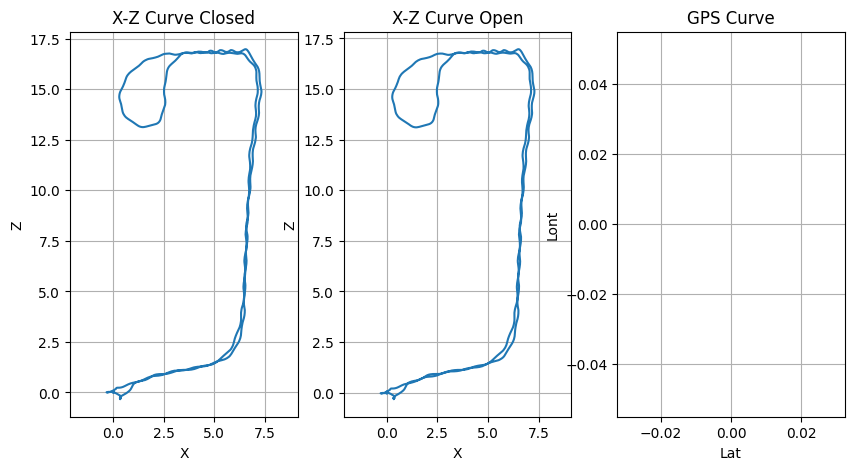

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].plot(poses_closed[:, 1], poses_closed[:, 3], '-')
axes[0].set_title('X-Z Curve Closed')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Z')
axes[0].axis('equal')
axes[0].grid(True)

axes[1].plot(poses_open[:, 1], poses_open[:, 3], '-')
axes[1].set_title('X-Z Curve Open')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')
axes[1].axis('equal')
axes[1].grid(True)

axes[2].plot(gps_data[:, 1], gps_data[:, 2], '-')
axes[2].set_title('GPS Curve')
axes[2].set_xlabel('Lat')
axes[2].set_ylabel('Lont')
axes[2].axis('equal')
axes[2].grid(True)

plt.show()